In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, log_loss


In [2]:
def reduce_memory_usage(df):
	"""Reduce memory usage of a DataFrame by downcasting numerical columns."""
	for col in df.select_dtypes(include=['float64', 'int64']).columns:
		if df[col].dtype == 'float64':
			df[col] = pd.to_numeric(df[col], downcast='float')
		elif df[col].dtype == 'int64':
			df[col] = pd.to_numeric(df[col], downcast='integer')
	return df

train_transaction = pd.read_csv(r"C:\Users\Admin\Downloads\train_transaction.csv")
train_identity = pd.read_csv(r"C:\Users\Admin\Downloads\train_identity.csv")

test_transaction = pd.read_csv(r"C:\Users\Admin\Downloads\test_transaction.csv")
test_identity = pd.read_csv(r"C:\Users\Admin\Downloads\test_identity.csv")

# Reduce memory usage of each DataFrame
train_transaction = reduce_memory_usage(train_transaction)
train_identity = reduce_memory_usage(train_identity)
test_transaction = reduce_memory_usage(test_transaction)
test_identity = reduce_memory_usage(test_identity)

# Gộp các bảng theo TransactionID
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')


In [3]:
train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.950001,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.describe

<bound method NDFrame.describe of         TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400       68.500000         W   
1             2987001        0          86401       29.000000         W   
2             2987002        0          86469       59.000000         W   
3             2987003        0          86499       50.000000         W   
4             2987004        0          86506       50.000000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047       49.000000         W   
590536        3577536        0       15811049       39.500000         W   
590537        3577537        0       15811079       30.950001         W   
590538        3577538        0       15811088      117.000000         W   
590539        3577539        0       15811131      279.950012         W   

        card1  card2  card3       card4  card5  ...              

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(399), int16(1), int32(2), int8(1), object(31)
memory usage: 1.0+ GB


In [6]:
train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64

In [7]:
# Kích thước dữ liệu
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Tỉ lệ missing
missing = train.isnull().sum() / len(train)
missing = missing[missing > 0].sort_values(ascending=False)

# Top biến missing nhiều nhất
missing.head(10)


Train shape: (590540, 434)
Test shape: (506691, 433)


id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
dtype: float64

In [8]:
# Cột dạng object
object_cols = train.select_dtypes(include='object').columns.tolist()

# Cột dạng số
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Cột datetime
train['TransactionDT'] = pd.to_datetime(train['TransactionDT'], unit='s', origin='2017-11-30')
test['TransactionDT'] = pd.to_datetime(test['TransactionDT'], unit='s', origin='2017-11-30')


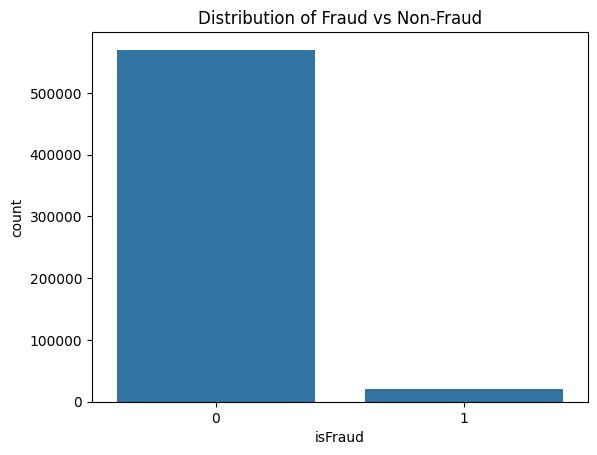

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


In [9]:
# Phân phối nhãn
sns.countplot(x='isFraud', data=train)
plt.title('Distribution of Fraud vs Non-Fraud')
plt.show()

# Tỉ lệ
print(train['isFraud'].value_counts(normalize=True))


In [10]:
# Mx binary flags
for col in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    train[col] = train[col].map({'T': 1, 'F': 0})

In [11]:
# Chuẩn hóa thiết bị
train['id_30'] = train['id_30'].str.extract(r'([a-zA-Z]+)')
train['id_31'] = train['id_31'].str.lower().str.split().str[0]

In [12]:
train['hour'] = train['TransactionDT'].dt.hour
train['day'] = train['TransactionDT'].dt.day
train['weekday'] = train['TransactionDT'].dt.weekday


In [13]:
# Lấy các cột V1–V339
v_cols = [f'V{i}' for i in range(1, 340)]

# Điền NA bằng 0 (hoặc có thể dùng mean nếu cần)
v_data = train[v_cols].fillna(0)

# Chuẩn hóa
scaler = StandardScaler()
v_scaled = scaler.fit_transform(v_data)

# Giảm chiều bằng PCA (2 chiều để trực quan hóa)
pca = PCA(n_components=2)
v_pca = pca.fit_transform(v_scaled)

# Tạo DataFrame kết quả
pca_columns = [f'PCA{i+1}' for i in range(v_pca.shape[1])]
pca_df = pd.DataFrame(v_pca, columns=pca_columns)
pca_df['isFraud'] = train['isFraud'].values

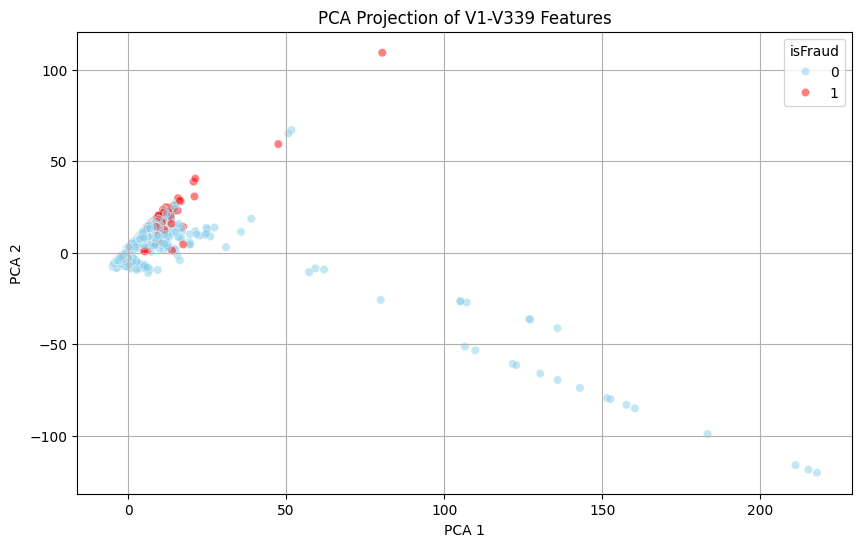

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='isFraud',
    data=pca_df.sample(10000),
    alpha=0.5,
    palette={0: 'skyblue', 1: 'red'}
)
plt.title('PCA Projection of V1-V339 Features')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='isFraud', loc='best')
plt.grid(True)
plt.show()

# Lấy dữ liệu đã chuẩn hóa
v_data_sample = v_scaled[:5000, :2]  # lấy 2 chiều đầu (V1, V2) để dễ trực quan



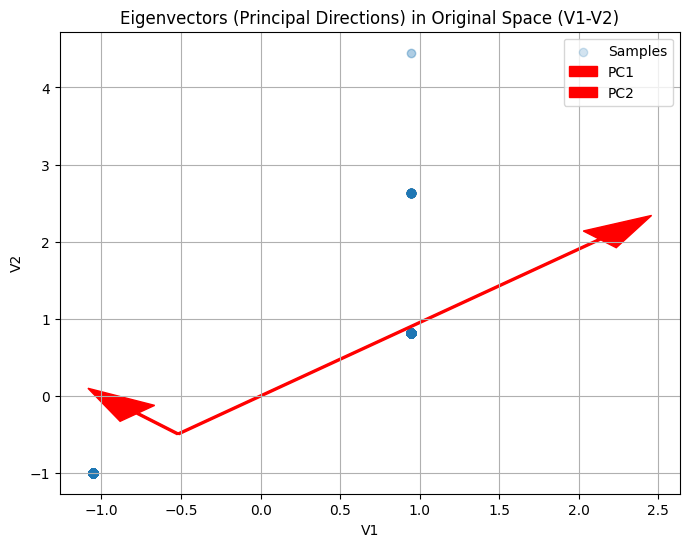

In [15]:
# Tính mean và eigenvector
mean = np.mean(v_data_sample, axis=0)
cov = np.cov(v_data_sample.T)
eigenvalues, eigenvectors = np.linalg.eig(cov)

# Vẽ dữ liệu và vector chính
plt.figure(figsize=(8,6))
plt.scatter(v_data_sample[:, 0], v_data_sample[:, 1], alpha=0.2, label='Samples')

# Vẽ các trục phương sai chính
for i in range(2):
    vec = eigenvectors[:, i]
    scale = np.sqrt(eigenvalues[i])
    plt.arrow(mean[0], mean[1], vec[0]*scale*3, vec[1]*scale*3,
              color='red', width=0.02, head_width=0.3, label=f'PC{i+1}')

plt.title("Eigenvectors (Principal Directions) in Original Space (V1-V2)")
plt.xlabel('V1')
plt.ylabel('V2')
plt.grid(True)
plt.legend()
plt.show()


1. PCA Projection of V1-V339 Features
- Purpose: Reduce 339 features (V1–V339) to 2 principal components (PCA1, PCA2) for visualization.
- Visualization: Scatter plot with PCA1 and PCA2 as axes, colored by isFraud (0: skyblue, 1: red).
- Key Insight: If isFraud groups are separable, PCA effectively captures variance relevant to fraud detection.
2. Eigenvectors in Original Space (V1-V2)
- Purpose: Visualize principal directions in the original feature space (V1, V2).
- Visualization: Scatter plot of samples with red arrows representing eigenvectors (principal directions).
- Key Insight: Eigenvectors align with the directions of maximum variance in the data.
3. PCA Workflow
Steps:
Normalize data using StandardScaler.
- Apply PCA to reduce dimensions (n_components=2).
- Visualize top 2 components (PCA1, PCA2).
- Validation: Ensure eigenvectors align with data variance and check separability of fraud vs. non-fraud groups.

In [16]:
# Group columns into subsets (e.g., V1-V339)
v_cols = [f'V{i}' for i in range(1, 340)]

# Calculate the correlation matrix for the group
correlation_matrix = train[v_cols].corr().abs()

# Select a maximum-sized subset of uncorrelated columns
selected_columns = []
threshold = 0.8  # Define a correlation threshold

for col in correlation_matrix.columns:
    if all(correlation_matrix[col][selected_columns] < threshold):
        selected_columns.append(col)

print(f"Selected {len(selected_columns)} uncorrelated columns.")

Selected 68 uncorrelated columns.


#### Features Engineering

In [17]:
# Convert TransactionDT to a timestamp (integer) for calculations
SECONDS_IN_DAY = 60 * 60 * 24
train['TransactionDT_numeric'] = train['TransactionDT'].astype('int64') / 1e9  # Convert to seconds
test['TransactionDT_numeric'] = test['TransactionDT'].astype('int64') / 1e9  # Convert to seconds

# Calculate D1n, D4n, D10n, D15n
train['D1n'] = np.floor(train['TransactionDT_numeric'] / SECONDS_IN_DAY) - train['D1']
train['D4n'] = np.floor(train['TransactionDT_numeric'] / SECONDS_IN_DAY) - train['D4']
train['D10n'] = np.floor(train['TransactionDT_numeric'] / SECONDS_IN_DAY) - train['D10']
train['D15n'] = np.floor(train['TransactionDT_numeric'] / SECONDS_IN_DAY) - train['D15']

# Create UID
train['uid'] = train['card1'].astype(str) + '_' + train['addr1'].astype(str) + '_' + train['D1n'].astype(str)

# Define the encode_AG function
def encode_AG(columns, group_by, agg_funcs):
	"""
	Perform aggregation and encoding on specified columns.
	
	Parameters:
		columns (list): List of columns to aggregate.
		group_by (list): List of columns to group by.
		agg_funcs (list): List of aggregation functions (e.g., 'mean', 'std', 'nunique').
	"""
	for col in columns:
		for agg_func in agg_funcs:
			new_col_name = f"{col}_{'_'.join(group_by)}_{agg_func}"
			train[new_col_name] = train.groupby(group_by)[col].transform(agg_func)

# Perform encoding
encode_AG(['D4n', 'D10n', 'D15n'], ['uid'], ['mean', 'std'])
encode_AG(['TransactionAmt', 'dist1'], ['uid'], ['mean', 'std'])
encode_AG(['C13'], ['uid'], ['nunique'])

In [18]:
def create_uid_features(df):
    # --- Base UID Construction ---
    df['card1'] = df['card1'].astype(str)  # Ensure card1 is string
    df['addr1'] = df['addr1'].astype(str)  # Ensure addr1 is string
    df['D1n'] = df['D1n'].astype(str)     # Ensure D1n is string

    df['uid'] = df['card1'] + '_' + df['addr1'] + '_' + df['D1n'].astype(str)
    df['uid2'] = df['uid'] + '_' + df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['uid3'] = df['uid2'] + '_' + df['addr1'] + '_' + df['addr2'].astype(str)

    # --- Aggregated features by uid ---
    for uid_col in ['uid', 'uid2', 'uid3']:
        # Transaction count
        df[f'{uid_col}_trans_count'] = df.groupby(uid_col)['TransactionAmt'].transform('count')

        # Transaction amount stats
        df[f'{uid_col}_amt_mean'] = df.groupby(uid_col)['TransactionAmt'].transform('mean')
        df[f'{uid_col}_amt_std'] = df.groupby(uid_col)['TransactionAmt'].transform('std')
        df[f'{uid_col}_amt_max'] = df.groupby(uid_col)['TransactionAmt'].transform('max')
        df[f'{uid_col}_amt_min'] = df.groupby(uid_col)['TransactionAmt'].transform('min')

        # Normalized transaction amount
        df[f'{uid_col}_amt_over_mean'] = df['TransactionAmt'] / (df[f'{uid_col}_amt_mean'] + 1e-6)

        # Time between transactions
        df.sort_values(by=[uid_col, 'TransactionDT'], inplace=True)
        df[f'{uid_col}_prev_D1n'] = df.groupby(uid_col)['D1n'].shift(1)
        df[f'{uid_col}_delta_time'] = df['D1n'].astype(float) - df[f'{uid_col}_prev_D1n'].astype(float)

        # Rolling transaction count in short window (simulate 6h/24h)
        df[f'{uid_col}_rolling_trans_6h'] = (
            df.groupby(uid_col)['TransactionDT']
              .transform(lambda x: x.rolling(window=3, min_periods=1).count())
        )

    # --- Email Domain Matching (optional if available) ---
    if 'P_emaildomain' in df.columns:
        df['email_suffix'] = df['P_emaildomain'].astype(str).str.extract(r'(@.+)')
        df['is_free_email'] = df['email_suffix'].isin([
            '@gmail.com', '@yahoo.com', '@hotmail.com', '@outlook.com'
        ]).astype(int)

    # --- Device Info Matching (if available) ---
    if 'DeviceInfo' in df.columns:
        df['DeviceInfo_clean'] = df['DeviceInfo'].astype(str).str.lower().str.extract(r'([a-zA-Z]+)').fillna('unknown')
        df['is_known_device'] = df['DeviceInfo_clean'].isin(['samsung', 'huawei', 'apple', 'lenovo']).astype(int)

    # --- Fill missing with default (for LightGBM compatibility) ---
    df.fillna(-999, inplace=True)

    return df

In [19]:
create_uid_features(train)

C:\Users\Admin\AppData\Local\Temp\ipykernel_472\408455297.py:49: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(-999, inplace=True)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,uid3_amt_max,uid3_amt_min,uid3_amt_over_mean,uid3_prev_D1n,uid3_delta_time,uid3_rolling_trans_6h,email_suffix,is_free_email,DeviceInfo_clean,is_known_device
182988,3169988,0,2018-01-15 21:14:11,29.000000,W,10000,111.0,150.0,mastercard,117.0,...,29.000000,29.000,1.000000,-999,-999.0,1.0,-999,0,nan,0
341484,3328484,0,2018-03-07 11:23:35,39.394001,C,10003,555.0,128.0,visa,226.0,...,39.394001,10.755,1.783846,-999,-999.0,1.0,-999,0,s,0
350343,3337343,0,2018-03-09 22:34:42,10.755000,C,10003,555.0,128.0,visa,226.0,...,39.394001,10.755,0.487010,17590.0,0.0,2.0,-999,0,s,0
350365,3337365,0,2018-03-09 22:40:15,19.093000,C,10003,555.0,128.0,visa,226.0,...,39.394001,10.755,0.864572,17590.0,0.0,3.0,-999,0,s,0
350822,3337822,0,2018-03-10 00:40:05,19.093000,C,10003,555.0,128.0,visa,226.0,...,39.394001,10.755,0.864572,17590.0,0.0,3.0,-999,0,nan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533757,3520757,0,2018-05-11 18:30:30,25.000000,S,9999,174.0,150.0,visa,226.0,...,30.000000,20.000,1.136364,17535.0,0.0,3.0,-999,0,rv,0
542705,3529705,0,2018-05-14 17:51:17,20.000000,S,9999,174.0,150.0,visa,226.0,...,30.000000,20.000,0.909091,17535.0,0.0,3.0,-999,0,rv,0
545261,3532261,0,2018-05-15 15:31:08,20.000000,S,9999,174.0,150.0,visa,226.0,...,30.000000,20.000,0.909091,17535.0,0.0,3.0,-999,0,rv,0
548099,3535099,0,2018-05-16 14:53:05,30.000000,S,9999,174.0,150.0,visa,226.0,...,30.000000,20.000,1.363636,17535.0,0.0,3.0,-999,0,rv,0


In [20]:
def create_C_features(df):
    c_cols = [f'C{i}' for i in range(1, 15) if f'C{i}' in df.columns]
    
    df['C_sum'] = df[c_cols].sum(axis=1)
    df['C_mean'] = df[c_cols].mean(axis=1)
    df['C_std'] = df[c_cols].std(axis=1)
    
    for col in c_cols:
        df[f'{col}_over_mean'] = df[col] / (df['C_mean'] + 1e-6)
        df[f'{col}_is_outlier'] = (df[col] > df['C_mean'] + 2 * df['C_std']).astype(int)
        
    return df

In [21]:
create_C_features(train)

C:\Users\Admin\AppData\Local\Temp\ipykernel_472\3579918982.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_over_mean'] = df[col] / (df['C_mean'] + 1e-6)
C:\Users\Admin\AppData\Local\Temp\ipykernel_472\3579918982.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_is_outlier'] = (df[col] > df['C_mean'] + 2 * df['C_std']).astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_472\3579918982.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,C10_over_mean,C10_is_outlier,C11_over_mean,C11_is_outlier,C12_over_mean,C12_is_outlier,C13_over_mean,C13_is_outlier,C14_over_mean,C14_is_outlier
182988,3169988,0,2018-01-15 21:14:11,29.000000,W,10000,111.0,150.0,mastercard,117.0,...,0.000000,0,1.555553,0,0.000000,0,6.222212,1,1.555553,0
341484,3328484,0,2018-03-07 11:23:35,39.394001,C,10003,555.0,128.0,visa,226.0,...,1.749998,0,1.749998,0,1.749998,0,1.749998,0,0.874999,0
350343,3337343,0,2018-03-09 22:34:42,10.755000,C,10003,555.0,128.0,visa,226.0,...,2.210525,0,1.473683,0,1.473683,0,2.210525,0,0.736842,0
350365,3337365,0,2018-03-09 22:40:15,19.093000,C,10003,555.0,128.0,visa,226.0,...,2.099998,0,1.399999,0,1.399999,0,2.099998,0,0.700000,0
350822,3337822,0,2018-03-10 00:40:05,19.093000,C,10003,555.0,128.0,visa,226.0,...,2.333332,0,1.166666,0,1.166666,0,2.333332,0,0.583333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533757,3520757,0,2018-05-11 18:30:30,25.000000,S,9999,174.0,150.0,visa,226.0,...,0.538461,0,1.615384,0,0.000000,0,5.384613,1,1.076923,0
542705,3529705,0,2018-05-14 17:51:17,20.000000,S,9999,174.0,150.0,visa,226.0,...,0.518518,0,1.555555,0,0.000000,0,5.703701,1,1.037037,0
545261,3532261,0,2018-05-15 15:31:08,20.000000,S,9999,174.0,150.0,visa,226.0,...,0.500000,0,1.499999,0,0.000000,0,5.999997,1,1.000000,0
548099,3535099,0,2018-05-16 14:53:05,30.000000,S,9999,174.0,150.0,visa,226.0,...,0.482758,0,1.448275,0,0.000000,0,6.275859,1,0.965517,0


In [22]:
def create_V_features(df, n_components=2):
    v_cols = [f'V{i}' for i in range(1, 340) if f'V{i}' in df.columns]
    df_v = df[v_cols].fillna(-999)
    
    pca = PCA(n_components=n_components, random_state=42)
    v_pca = pca.fit_transform(df_v)
    
    for i in range(n_components):
        df[f'V_PCA_{i+1}'] = v_pca[:, i]
    
    df['V_mean'] = df_v.mean(axis=1)
    df['V_std'] = df_v.std(axis=1)
    
    return df

In [23]:
create_V_features(train)

C:\Users\Admin\AppData\Local\Temp\ipykernel_472\992692965.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'V_PCA_{i+1}'] = v_pca[:, i]
C:\Users\Admin\AppData\Local\Temp\ipykernel_472\992692965.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'V_PCA_{i+1}'] = v_pca[:, i]
C:\Users\Admin\AppData\Local\Temp\ipykernel_472\992692965.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,C12_over_mean,C12_is_outlier,C13_over_mean,C13_is_outlier,C14_over_mean,C14_is_outlier,V_PCA_1,V_PCA_2,V_mean,V_std
182988,3169988,0,2018-01-15 21:14:11,29.000000,W,10000,111.0,150.0,mastercard,117.0,...,0.000000,0,6.222212,1,1.555553,0,-6826.299316,-1420.748047,-500.840698,500.369598
341484,3328484,0,2018-03-07 11:23:35,39.394001,C,10003,555.0,128.0,visa,226.0,...,1.749998,0,1.749998,0,0.874999,0,-6639.757812,233.678223,-168.813843,377.813568
350343,3337343,0,2018-03-09 22:34:42,10.755000,C,10003,555.0,128.0,visa,226.0,...,1.473683,0,2.210525,0,0.736842,0,-6578.398438,382.929810,-280.137665,452.676544
350365,3337365,0,2018-03-09 22:40:15,19.093000,C,10003,555.0,128.0,visa,226.0,...,1.399999,0,2.099998,0,0.700000,0,-6578.094727,397.500244,-279.296417,453.246643
350822,3337822,0,2018-03-10 00:40:05,19.093000,C,10003,555.0,128.0,visa,226.0,...,1.166666,0,2.333332,0,0.583333,0,-6579.025391,381.194824,-280.622131,452.345215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533757,3520757,0,2018-05-11 18:30:30,25.000000,S,9999,174.0,150.0,visa,226.0,...,0.000000,0,5.384613,1,1.076923,0,-5354.133301,1487.305542,-152.265488,360.990234
542705,3529705,0,2018-05-14 17:51:17,20.000000,S,9999,174.0,150.0,visa,226.0,...,0.000000,0,5.703701,1,1.037037,0,-5369.805664,1500.111328,-83.280235,280.654999
545261,3532261,0,2018-05-15 15:31:08,20.000000,S,9999,174.0,150.0,visa,226.0,...,0.000000,0,5.999997,1,1.000000,0,-5348.164062,1551.409058,-81.424782,281.402924
548099,3535099,0,2018-05-16 14:53:05,30.000000,S,9999,174.0,150.0,visa,226.0,...,0.000000,0,6.275859,1,0.965517,0,-5327.845703,1594.307129,-80.082596,282.049622


In [24]:
def create_M_features(df):
    m_cols = [f'M{i}' for i in range(1, 10) if f'M{i}' in df.columns]
    
    for col in m_cols:
        df[col] = df[col].map({'T': 1, 'F': 0})
    
    df['M_flags_sum'] = df[m_cols].sum(axis=1)
    df['M_flags_mean'] = df[m_cols].mean(axis=1)
    
    if set(['M1', 'M2']).issubset(df.columns):
        df['M1_M2_combo'] = df['M1'].astype(str) + '_' + df['M2'].astype(str)
    
    return df


In [25]:
create_M_features(train)

C:\Users\Admin\AppData\Local\Temp\ipykernel_472\4035962947.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['M_flags_sum'] = df[m_cols].sum(axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_472\4035962947.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['M_flags_mean'] = df[m_cols].mean(axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_472\4035962947.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,C13_is_outlier,C14_over_mean,C14_is_outlier,V_PCA_1,V_PCA_2,V_mean,V_std,M_flags_sum,M_flags_mean,M1_M2_combo
182988,3169988,0,2018-01-15 21:14:11,29.000000,W,10000,111.0,150.0,mastercard,117.0,...,1,1.555553,0,-6826.299316,-1420.748047,-500.840698,500.369598,0.0,NaN,nan_nan
341484,3328484,0,2018-03-07 11:23:35,39.394001,C,10003,555.0,128.0,visa,226.0,...,0,0.874999,0,-6639.757812,233.678223,-168.813843,377.813568,0.0,NaN,nan_nan
350343,3337343,0,2018-03-09 22:34:42,10.755000,C,10003,555.0,128.0,visa,226.0,...,0,0.736842,0,-6578.398438,382.929810,-280.137665,452.676544,0.0,NaN,nan_nan
350365,3337365,0,2018-03-09 22:40:15,19.093000,C,10003,555.0,128.0,visa,226.0,...,0,0.700000,0,-6578.094727,397.500244,-279.296417,453.246643,0.0,NaN,nan_nan
350822,3337822,0,2018-03-10 00:40:05,19.093000,C,10003,555.0,128.0,visa,226.0,...,0,0.583333,0,-6579.025391,381.194824,-280.622131,452.345215,0.0,NaN,nan_nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533757,3520757,0,2018-05-11 18:30:30,25.000000,S,9999,174.0,150.0,visa,226.0,...,1,1.076923,0,-5354.133301,1487.305542,-152.265488,360.990234,0.0,NaN,nan_nan
542705,3529705,0,2018-05-14 17:51:17,20.000000,S,9999,174.0,150.0,visa,226.0,...,1,1.037037,0,-5369.805664,1500.111328,-83.280235,280.654999,0.0,NaN,nan_nan
545261,3532261,0,2018-05-15 15:31:08,20.000000,S,9999,174.0,150.0,visa,226.0,...,1,1.000000,0,-5348.164062,1551.409058,-81.424782,281.402924,0.0,NaN,nan_nan
548099,3535099,0,2018-05-16 14:53:05,30.000000,S,9999,174.0,150.0,visa,226.0,...,1,0.965517,0,-5327.845703,1594.307129,-80.082596,282.049622,0.0,NaN,nan_nan


In [26]:
def label_encode_dataframe(df):
    for col in df.columns:
        if df[col].dtype == 'object' or str(df[col].dtype).startswith('category'):
            df[col] = df[col].fillna('missing')
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    return df

In [27]:
label_encode_dataframe(train)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,C13_is_outlier,C14_over_mean,C14_is_outlier,V_PCA_1,V_PCA_2,V_mean,V_std,M_flags_sum,M_flags_mean,M1_M2_combo
182988,3169988,0,2018-01-15 21:14:11,29.000000,4,1,111.0,150.0,3,117.0,...,1,1.555553,0,-6826.299316,-1420.748047,-500.840698,500.369598,0.0,NaN,0
341484,3328484,0,2018-03-07 11:23:35,39.394001,0,2,555.0,128.0,4,226.0,...,0,0.874999,0,-6639.757812,233.678223,-168.813843,377.813568,0.0,NaN,0
350343,3337343,0,2018-03-09 22:34:42,10.755000,0,2,555.0,128.0,4,226.0,...,0,0.736842,0,-6578.398438,382.929810,-280.137665,452.676544,0.0,NaN,0
350365,3337365,0,2018-03-09 22:40:15,19.093000,0,2,555.0,128.0,4,226.0,...,0,0.700000,0,-6578.094727,397.500244,-279.296417,453.246643,0.0,NaN,0
350822,3337822,0,2018-03-10 00:40:05,19.093000,0,2,555.0,128.0,4,226.0,...,0,0.583333,0,-6579.025391,381.194824,-280.622131,452.345215,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533757,3520757,0,2018-05-11 18:30:30,25.000000,3,13552,174.0,150.0,4,226.0,...,1,1.076923,0,-5354.133301,1487.305542,-152.265488,360.990234,0.0,NaN,0
542705,3529705,0,2018-05-14 17:51:17,20.000000,3,13552,174.0,150.0,4,226.0,...,1,1.037037,0,-5369.805664,1500.111328,-83.280235,280.654999,0.0,NaN,0
545261,3532261,0,2018-05-15 15:31:08,20.000000,3,13552,174.0,150.0,4,226.0,...,1,1.000000,0,-5348.164062,1551.409058,-81.424782,281.402924,0.0,NaN,0
548099,3535099,0,2018-05-16 14:53:05,30.000000,3,13552,174.0,150.0,4,226.0,...,1,0.965517,0,-5327.845703,1594.307129,-80.082596,282.049622,0.0,NaN,0


In [28]:
df = pd.concat([train, test], axis=0, ignore_index=True)
df = reduce_memory_usage(df)
df = label_encode_dataframe(df)
df = df.fillna(-999)  # Fill missing values with -999 for LightGBM compatibility

#### Model Machine Learning

In [39]:
import os
import json
import joblib
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, log_loss, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score
)

def train_lgbm_model(df, target_col='isFraud'):
    # Tiền xử lý
    total_len = len(df)
    part = total_len // 10
    train_df = df.iloc[:6*part]
    valid_df = df.iloc[6*part:8*part]
    test_df = df.iloc[2*part:]

    print(f"✅ Dataset shapes -> Train: {train_df.shape}, Valid: {valid_df.shape}, Test: {test_df.shape}")

    # Feature
    features = [col for col in df.columns if col != target_col and not col.startswith('TransactionID')]
    X_train, y_train = train_df[features], train_df[target_col]
    X_valid, y_valid = valid_df[features], valid_df[target_col]
    X_test, y_test = test_df[features], test_df[target_col]

    # Dataset LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # Tham số
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'n_estimators': 500,
        'max_depth': 7,
    }

    # Huấn luyện
    print("🚀 Huấn luyện LightGBM...")
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    # Dự đoán
    valid_preds = model.predict(X_valid, num_iteration=model.best_iteration)
    test_preds = model.predict(X_test, num_iteration=model.best_iteration)

    # AUC & LogLoss
    auc = roc_auc_score(y_valid, valid_preds)
    lloss = log_loss(y_valid, valid_preds)
    print(f"🎯 Valid AUC: {auc:.5f} | LogLoss: {lloss:.5f}")

    # Độ quan trọng đặc trưng
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values(by='importance', ascending=False)

    # 🔥 ĐÁNH GIÁ HIỆU SUẤT
    threshold = 0.5
    y_pred_binary = (valid_preds >= threshold).astype(int)

    cm = confusion_matrix(y_valid, y_pred_binary)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print("\n📊 Classification Report:")
    print(classification_report(y_valid, y_pred_binary, digits=4))

    precision = precision_score(y_valid, y_pred_binary)
    recall = recall_score(y_valid, y_pred_binary)
    f1 = f1_score(y_valid, y_pred_binary)

    print(f"🔍 Precision: {precision:.4f}")
    print(f"🔍 Recall:    {recall:.4f}")
    print(f"🔍 F1 Score:  {f1:.4f}")

    # SAVE MODEL
    save_dir = r"C:\Users\Admin\Fraud-Detection-MLOps\artifacts"
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, "lgbm_model.pkl")
    joblib.dump(model, model_path)
    print(f"✅ Model saved to: {model_path}")

    # SAVE THÔNG TIN
    model_info = {
        "model_path": model_path,
        "features": features,
        "auc": round(auc, 5),
        "log_loss": round(lloss, 5),
        "precision": round(precision, 5),
        "recall": round(recall, 5),
        "f1_score": round(f1, 5),
        "timestamp": pd.Timestamp.now().isoformat()
    }
    info_path = os.path.join(save_dir, "model_info.json")
    with open(info_path, "w") as f:
        json.dump(model_info, f, indent=4)
    print(f"📝 Model info saved to: {info_path}")

    return model, importance, test_preds


 The target column 'isFraud' contains more than two unique values: [   0.    1. -999.].
 Rows with invalid target values have been removed. Remaining unique values: [0. 1.]
✅ Dataset shapes -> Train: (354324, 562), Valid: (118108, 562), Test: (472432, 562)
🚀 Huấn luyện LightGBM...


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11433, number of negative: 342891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53771
[LightGBM] [Info] Number of data points in the train set: 354324, number of used features: 503
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032267 -> initscore=-3.400909
[LightGBM] [Info] Start training from score -3.400909
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.914169	valid's auc: 0.886916
[100]	train's auc: 0.939364	valid's auc: 0.895539
[150]	train's auc: 0.949321	valid's auc: 0.898185
[200]	train's auc: 0.958405	valid's auc: 0.899141
[250]	train's auc: 0.96433	valid's auc: 0.902451
Early stopping, best iteration is:
[249]	train's auc: 0.964196	valid's auc: 0.902508
🎯 Valid AUC: 0.90251 | LogLoss: 0.09179


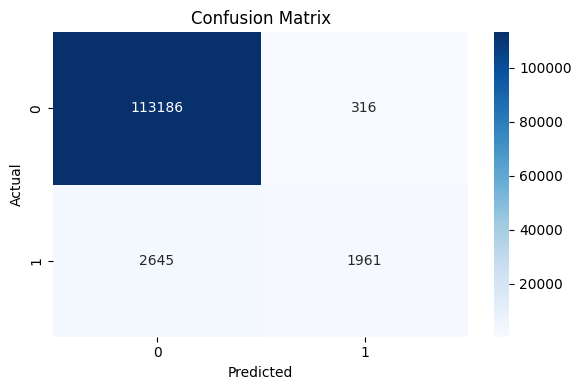


📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.9772    0.9972    0.9871    113502
         1.0     0.8612    0.4257    0.5698      4606

    accuracy                         0.9749    118108
   macro avg     0.9192    0.7115    0.7784    118108
weighted avg     0.9726    0.9749    0.9708    118108

🔍 Precision: 0.8612
🔍 Recall:    0.4257
🔍 F1 Score:  0.5698
✅ Model saved to: C:\Users\Admin\Fraud-Detection-MLOps\artifacts\lgbm_model.pkl
📝 Model info saved to: C:\Users\Admin\Fraud-Detection-MLOps\artifacts\model_info.json


(<lightgbm.basic.Booster at 0x1d58dc67cd0>,
              feature     importance
 511    C13_over_mean  117565.416141
 14                C1   56701.578124
 252             V201   30831.109913
 450  C13_uid_nunique   19421.801684
 359             V308   16538.361586
 ..               ...            ...
 273             V222       0.000000
 275             V224       0.000000
 278             V227       0.000000
 279             V228       0.000000
 559            id-38       0.000000
 
 [560 rows x 2 columns],
 array([0.00455983, 0.0020332 , 0.00743466, ..., 0.00724803, 0.00727654,
        0.03708642]))

In [40]:
# Define the target column
target_col = 'isFraud'

# Ensure all columns are numeric before training
df_numeric = df.select_dtypes(include=[np.number])  # Select only numeric columns
df_numeric[target_col] = df[target_col]  # Add the target column back if it was excluded

# Ensure the target column contains only binary values
unique_values = df_numeric[target_col].unique()
if len(unique_values) > 2:
	print(f" The target column '{target_col}' contains more than two unique values: {unique_values}.")
	# Remove rows with invalid target values
	valid_values = {0, 1}
	df_numeric = df_numeric[df_numeric[target_col].isin(valid_values)]
	print(f" Rows with invalid target values have been removed. Remaining unique values: {df_numeric[target_col].unique()}")

# Train the model with the numeric DataFrame
train_lgbm_model(df_numeric, target_col=target_col)